In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

root_folder = exp_path = Path().absolute().parent / "experiments" 

# Get latest generated folder
subfolder_list = [f for f in root_folder.iterdir()]
subfolder_list_creation_time = [f.stat().st_ctime for f in subfolder_list]
latest_subfolder_idx =  subfolder_list_creation_time.index(max(subfolder_list_creation_time))
experiment_path = subfolder_list[latest_subfolder_idx]

experiment_path = root_folder / "patience_2020-07-10_15h53_bis"
# Read CSV results
df = pd.read_csv(experiment_path / "results.csv")


In [88]:
# Config file
with open(experiment_path / "config.yml") as f:
     print(f.read())

experiment_name: patience
n_repeats: 10
scenario_params_list:
 - partners_count: 
     - 10
   amounts_per_partner: 
     - [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
   samples_split_option: 
     - ['basic', 'stratified']
   multi_partner_learning_approach:
     - 'fedavg'
     - 'seq-pure'
     - 'seq-with-final-agg'
     - 'seqavg'
   aggregation_weighting: 
     - 'uniform' 
   gradient_updates_per_pass_count: 
     - 4
     - 8
     - 16
   epoch_count: 
     - 100
   minibatch_count: 
     - 1
     - 2
     - 5
     - 10



In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 21 columns):
aggregation_weighting              94 non-null object
dataset_fraction_per_partner       94 non-null object
dataset_name                       94 non-null object
epoch_count                        94 non-null float64
final_relative_nb_samples          94 non-null object
gradient_updates_per_pass_count    94 non-null float64
is_early_stopping                  94 non-null float64
learning_computation_time_sec      94 non-null float64
minibatch_count                    94 non-null float64
mpl_nb_epochs_done                 94 non-null float64
mpl_test_score                     94 non-null float64
multi_partner_learning_approach    94 non-null object
nb_samples_used                    94 non-null float64
partners_count                     94 non-null float64
samples_split_description          94 non-null object
scenario_name                      94 non-null object
short_scenario_name     

In [111]:
scenario_ids = df.scenario_id.unique()
random_states = df.random_state.unique()
samples_split_descriptions = df.samples_split_description.unique()
dataset_fraction_per_partner_list = df.dataset_fraction_per_partner.unique()
gradient_updates_per_pass_count_list = df.gradient_updates_per_pass_count.unique()

print('Random state', random_states)
print('Scenario id', scenario_ids)
print('amounts_per_partner', amounts_per_partner_list)
print('gradient_updates_per_pass_count_list', gradient_updates_per_pass_count_list)
print()

df.info()


Random state [0 1]
Scenario id [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
amounts_per_partner ['[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]']
gradient_updates_per_pass_count_list [ 4.  8. 16.]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 22 columns):
aggregation_weighting              94 non-null object
dataset_fraction_per_partner       94 non-null object
dataset_name                       94 non-null object
epoch_count                        94 non-null float64
final_relative_nb_samples          94 non-null object
gradient_updates_per_pass_count    94 non-null float64
is_early_stopping                  94 non-null float64
learning_computation_time_sec      94 non-null float64
minibatch_count                    94 non-null float64
mpl_nb_epochs_done                 94 non-null float64
mpl_test_score                     94 non-null

In [106]:
df["computation_time_minutes"] = df.learning_computation_time_sec / 60
df.short_scenario_name = df.samples_split_description + df.dataset_fraction_per_partner + ' mb ' + df.minibatch_count.astype(str)
df.short_scenario_name.unique()
#df.contributivity_method = df.contributivity_method.str.replace('values', '')

array(['stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] mb 1.0',
       'stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] mb 2.0',
       'stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] mb 5.0',
       'stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] mb 10.0'],
      dtype=object)

In [107]:
# Helper function for plot
def get_x_tick_amount(df, scenario_id, partners_ids):
    
    x_ticks = []
    for partner_id in partners_ids:
        current_df = df[(df.scenario_id == scenario_id) & (df.partner_id == partner_id)]
        amount = current_df.amount_per_partner.unique()

        assert(len(amount) == 1)
        amount = amount[0]
    
        x_ticks.append('partner_' + str(partner_id) + ' ' + str(amount))
    return x_ticks

################################################
4.0


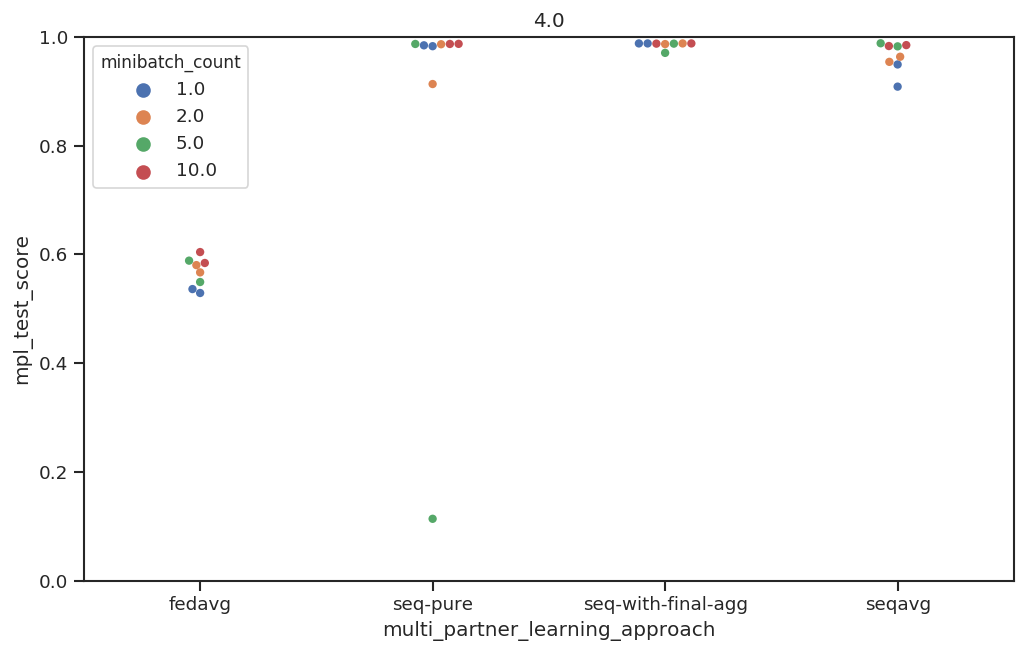

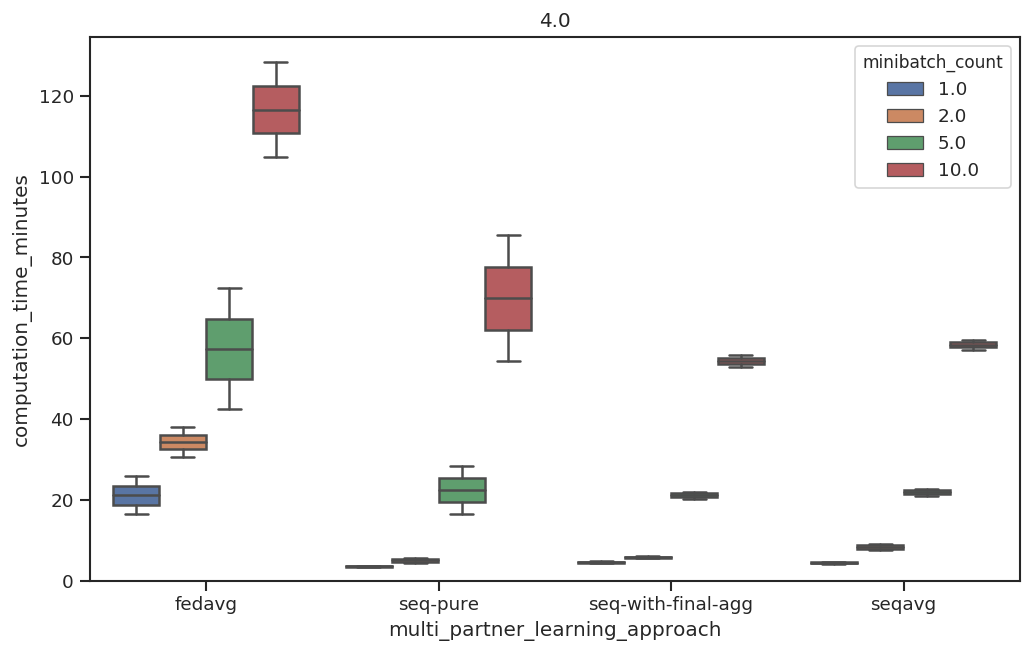

################################################
8.0


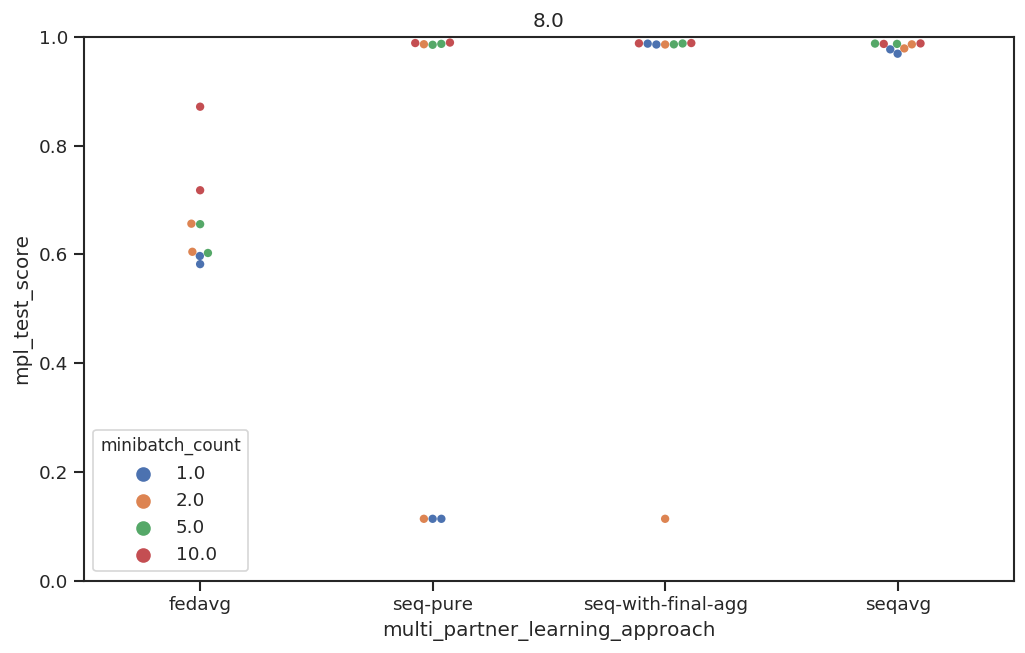

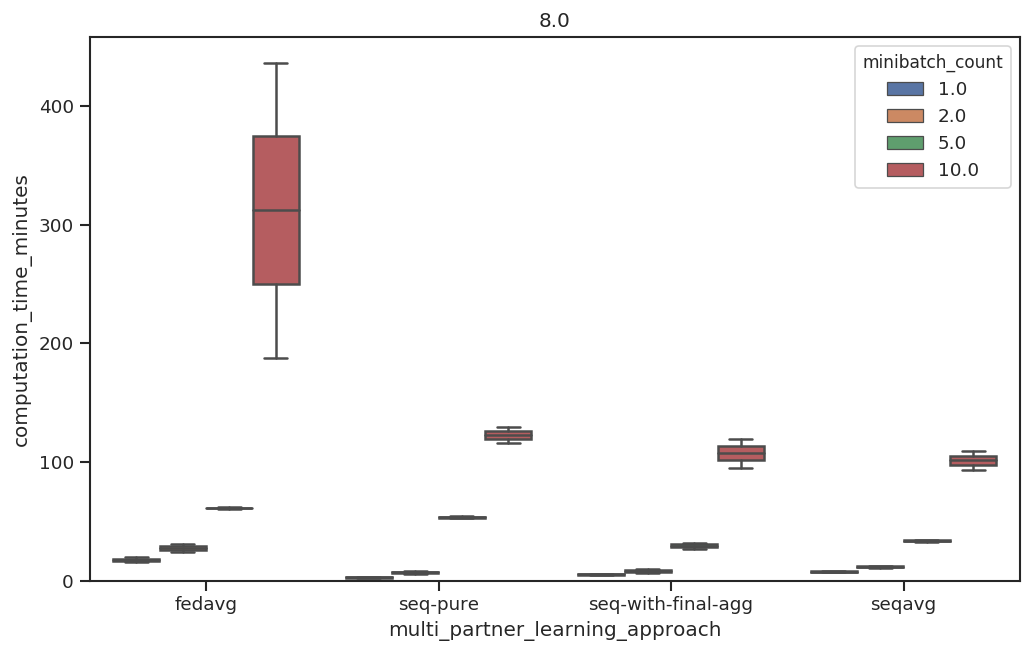

################################################
16.0


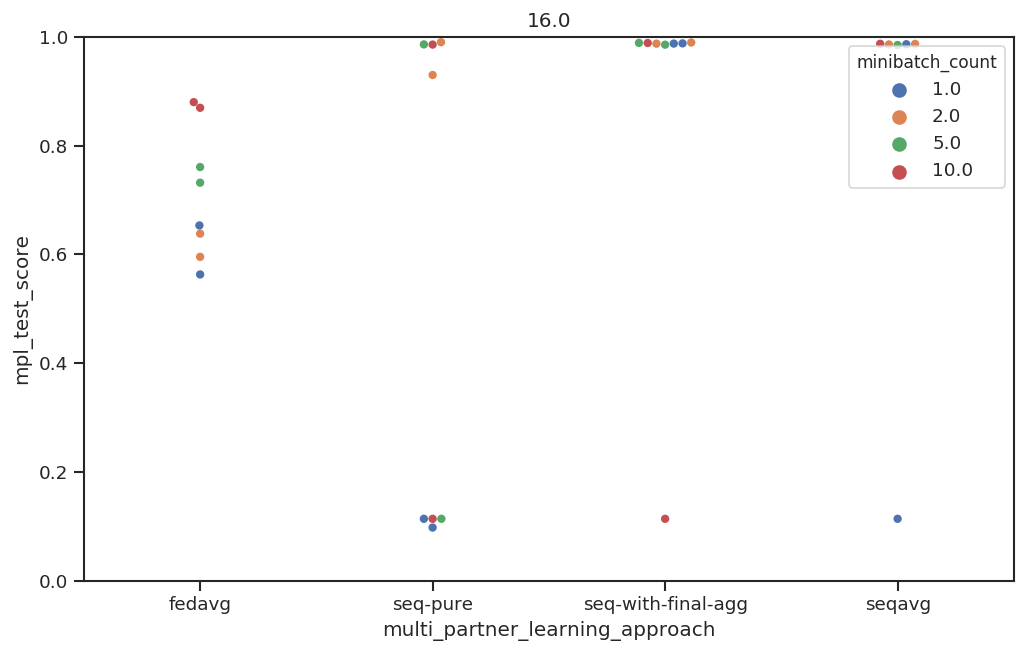

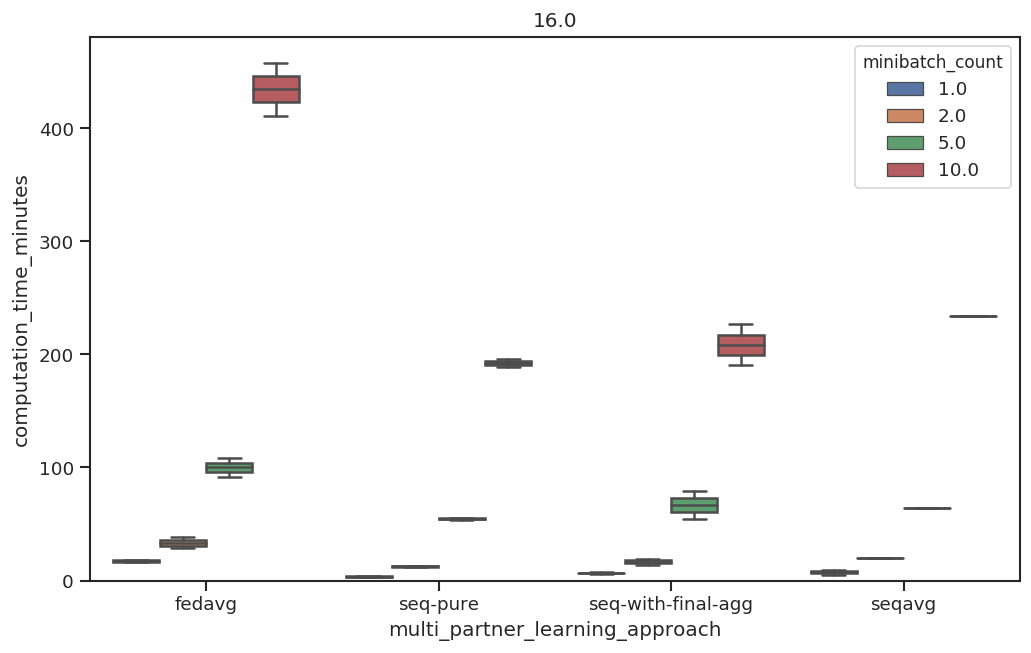

In [113]:
# Plot loop
for dataset_fraction_per_partner in dataset_fraction_per_partner_list:
    for gradient_updates_per_pass_count in gradient_updates_per_pass_count_list:
        
        current_df = df[(df.dataset_fraction_per_partner == dataset_fraction_per_partner) &
                        (df.gradient_updates_per_pass_count == gradient_updates_per_pass_count)]

        sns.set(style="ticks")
        #current_df.info()
        print("################################################")
        print(gradient_updates_per_pass_count)

        plt.figure(figsize=(10, 6), dpi=120)
        plt.title(gradient_updates_per_pass_count)
        ax = sns.swarmplot(x="multi_partner_learning_approach", y="mpl_test_score", hue="minibatch_count",
                           data=current_df)
        plt.ylim([0, 1])


        ax = plt.figure(figsize=(10, 6), dpi=120)
        plt.title(gradient_updates_per_pass_count)
        sns.boxplot(x="multi_partner_learning_approach", y="computation_time_minutes", hue="minibatch_count",
                         data=current_df)
        plt.ylim(bottom=0)


        plt.show()
    

## Losses

In [109]:
df_seq = df[(df.multi_partner_learning_approach == "seq-pure") & (df.minibatch_count == 1)]
df_seq.head(20)


,aggregation_weighting,dataset_fraction_per_partner,dataset_name,epoch_count,final_relative_nb_samples,gradient_updates_per_pass_count,is_early_stopping,learning_computation_time_sec,minibatch_count,mpl_nb_epochs_done,...,nb_samples_used,partners_count,samples_split_description,scenario_name,short_scenario_name,test_data_samples_count,train_data_samples_count,random_state,scenario_id,computation_time_minutes
12,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",mnist,100.0,"[0.10000257208261529, 0.10000257208261529, 0.1...",4.0,1.0,222.863520,1.0,78.0,...,38879.0,10.0,stratified,scenario_13_repeat_1_2020-07-11_13h32_f5d,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",10000.0,48000.0,0,12,3.714392
16,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",mnist,100.0,"[0.10000257208261529, 0.10000257208261529, 0.1...",8.0,1.0,143.377805,1.0,48.0,...,38879.0,10.0,stratified,scenario_17_repeat_1_2020-07-11_15h34_172,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",10000.0,48000.0,0,16,2.389630
20,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",mnist,100.0,"[0.10000257208261529, 0.10000257208261529, 0.1...",16.0,1.0,186.691492,1.0,31.0,...,38879.0,10.0,stratified,scenario_21_repeat_1_2020-07-11_18h44_5f6,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",10000.0,48000.0,0,20,3.111525
60,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",mnist,100.0,"[0.10000257208261529, 0.10000257208261529, 0.1...",4.0,1.0,199.082838,1.0,71.0,...,38879.0,10.0,stratified,scenario_13_repeat_2_2020-07-13_13h57_52a,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",10000.0,48000.0,1,12,3.318047
64,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",mnist,100.0,"[0.10000257208261529, 0.10000257208261529, 0.1...",8.0,1.0,160.814405,1.0,44.0,...,38879.0,10.0,stratified,scenario_17_repeat_2_2020-07-13_15h17_9cf,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",10000.0,48000.0,1,16,2.680240
68,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",mnist,100.0,"[0.10000257208261529, 0.10000257208261529, 0.1...",16.0,1.0,230.014373,1.0,36.0,...,38879.0,10.0,stratified,scenario_21_repeat_2_2020-07-13_18h17_bdf,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",10000.0,48000.0,1,20,3.833573


In [110]:
pd.set_option('display.max_seq_items', 40)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 30)
pd.set_option('display.min_rows', 30)
pd.set_option('display.width', None)


print(len(df_seq.scenario_name.unique()))
df_seq

6


,aggregation_weighting,dataset_fraction_per_partner,dataset_name,epoch_count,final_relative_nb_samples,gradient_updates_per_pass_count,is_early_stopping,learning_computation_time_sec,minibatch_count,mpl_nb_epochs_done,...,nb_samples_used,partners_count,samples_split_description,scenario_name,short_scenario_name,test_data_samples_count,train_data_samples_count,random_state,scenario_id,computation_time_minutes
12,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",mnist,100.0,"[0.10000257208261529, 0.10000257208261529, 0.1...",4.0,1.0,222.863520,1.0,78.0,...,38879.0,10.0,stratified,scenario_13_repeat_1_2020-07-11_13h32_f5d,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",10000.0,48000.0,0,12,3.714392
16,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",mnist,100.0,"[0.10000257208261529, 0.10000257208261529, 0.1...",8.0,1.0,143.377805,1.0,48.0,...,38879.0,10.0,stratified,scenario_17_repeat_1_2020-07-11_15h34_172,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",10000.0,48000.0,0,16,2.389630
20,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",mnist,100.0,"[0.10000257208261529, 0.10000257208261529, 0.1...",16.0,1.0,186.691492,1.0,31.0,...,38879.0,10.0,stratified,scenario_21_repeat_1_2020-07-11_18h44_5f6,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",10000.0,48000.0,0,20,3.111525
60,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",mnist,100.0,"[0.10000257208261529, 0.10000257208261529, 0.1...",4.0,1.0,199.082838,1.0,71.0,...,38879.0,10.0,stratified,scenario_13_repeat_2_2020-07-13_13h57_52a,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",10000.0,48000.0,1,12,3.318047
64,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",mnist,100.0,"[0.10000257208261529, 0.10000257208261529, 0.1...",8.0,1.0,160.814405,1.0,44.0,...,38879.0,10.0,stratified,scenario_17_repeat_2_2020-07-13_15h17_9cf,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",10000.0,48000.0,1,16,2.680240
68,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",mnist,100.0,"[0.10000257208261529, 0.10000257208261529, 0.1...",16.0,1.0,230.014373,1.0,36.0,...,38879.0,10.0,stratified,scenario_21_repeat_2_2020-07-13_18h17_bdf,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",10000.0,48000.0,1,20,3.833573


In [96]:
scenario_name = df_seq.scenario_name.iloc[0]
scenario_path = experiment_path / scenario_name
history_data_path = scenario_path / "history_data.p"

In [97]:
with open(history_data_path, 'rb') as f:
    loss_data = pickle.load(f)

In [98]:
loss_data.keys()

dict_keys(['loss_collective_models', 'score_matrix_per_partner', 'score_matrix_collective_models'])

In [99]:
score_matrix_per_partner = loss_data["score_matrix_per_partner"]
score_matrix_per_partner.shape

(100, 1, 10)

Text(0, 0.5, 'Local validation score')

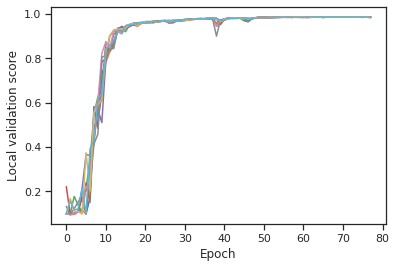

In [100]:

score_matrix_per_partner[score_matrix_per_partner == 0] = 'nan'

partner_idx = 0
plt.plot(score_matrix_per_partner[:, 0, :])
plt.xlabel("Epoch")
plt.ylabel("Local validation score")

(100, 2)


Text(0, 0.5, 'Global validation score')

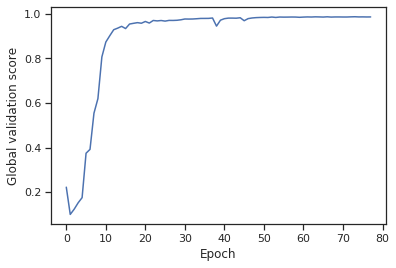

In [101]:
score_matrix_collective_models = loss_data["score_matrix_collective_models"]
print(score_matrix_collective_models.shape)
score_matrix_collective_models[score_matrix_collective_models == 0] = 'nan' # TODO don't init with zero

plt.plot(score_matrix_collective_models[:, 1])
plt.xlabel("Epoch")
plt.ylabel("Global validation score")


Text(0, 0.5, 'Global loss')

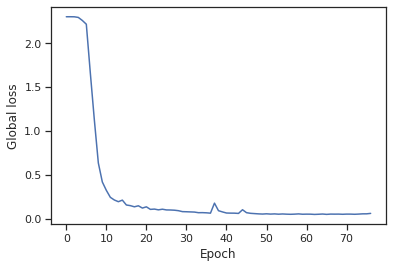

In [102]:
loss_collective_models = loss_data["loss_collective_models"]
loss_collective_models = loss_collective_models[1:] # TODO Why first loss is nan ?
plt.plot(np.arange(len(loss_collective_models)), loss_collective_models)
plt.xlabel("Epoch")
plt.ylabel("Global loss")

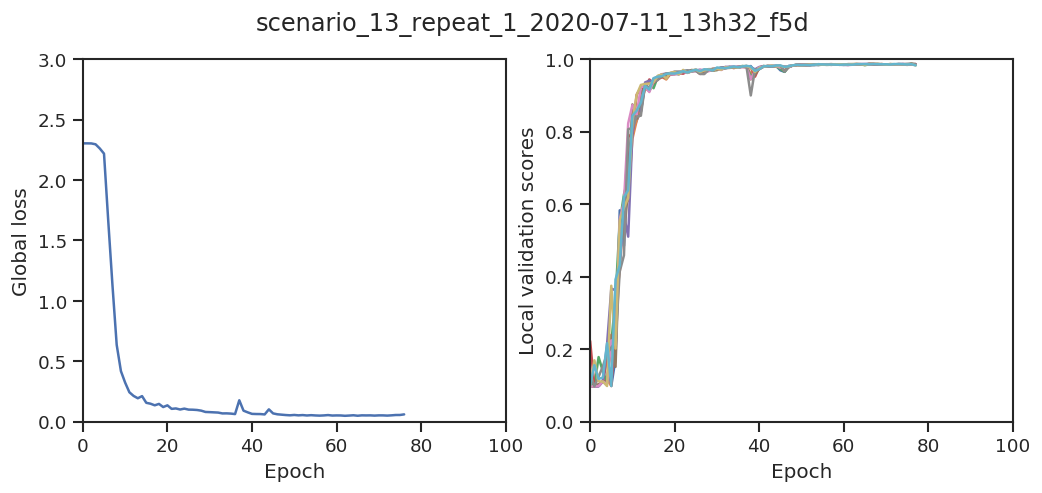

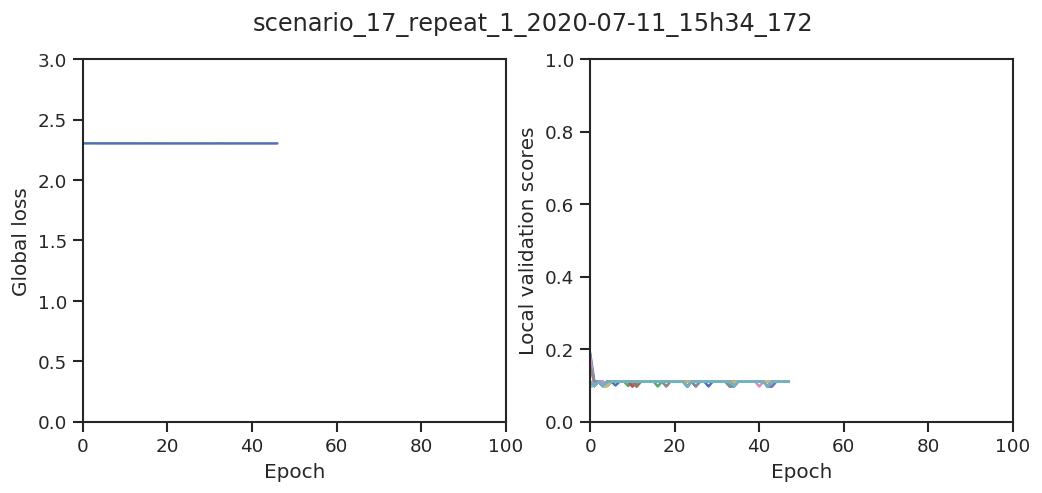

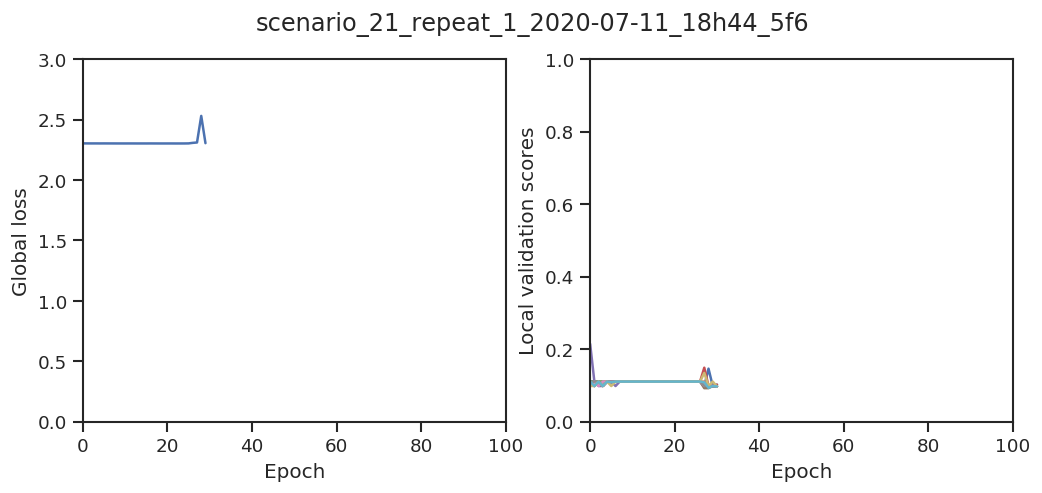

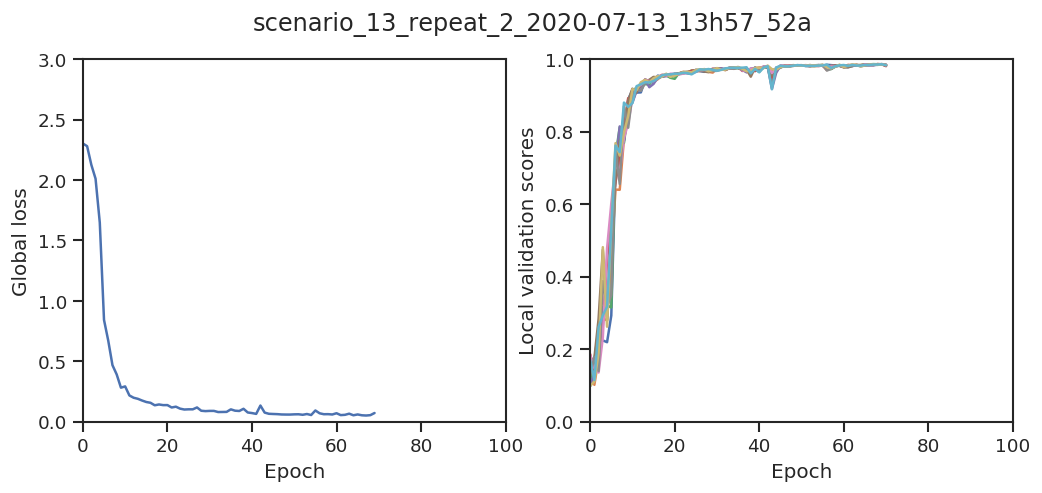

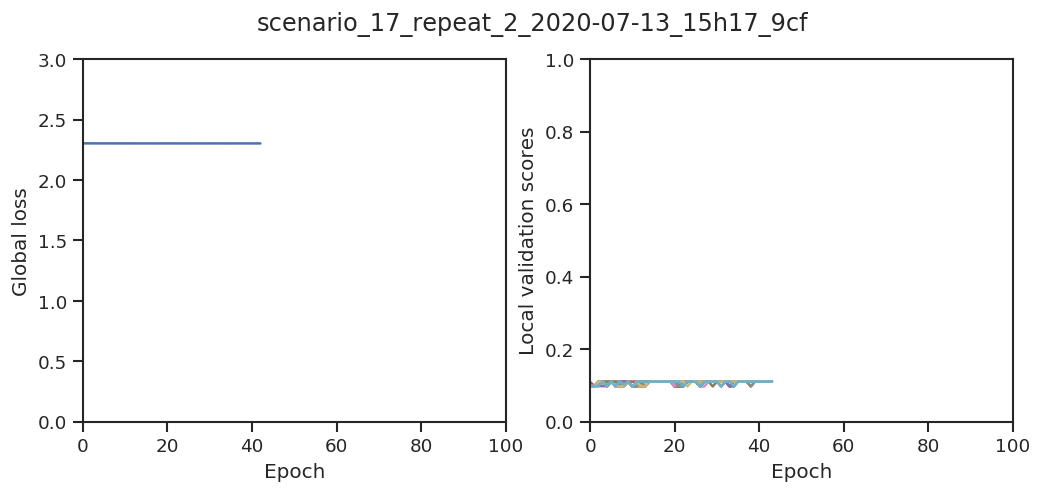

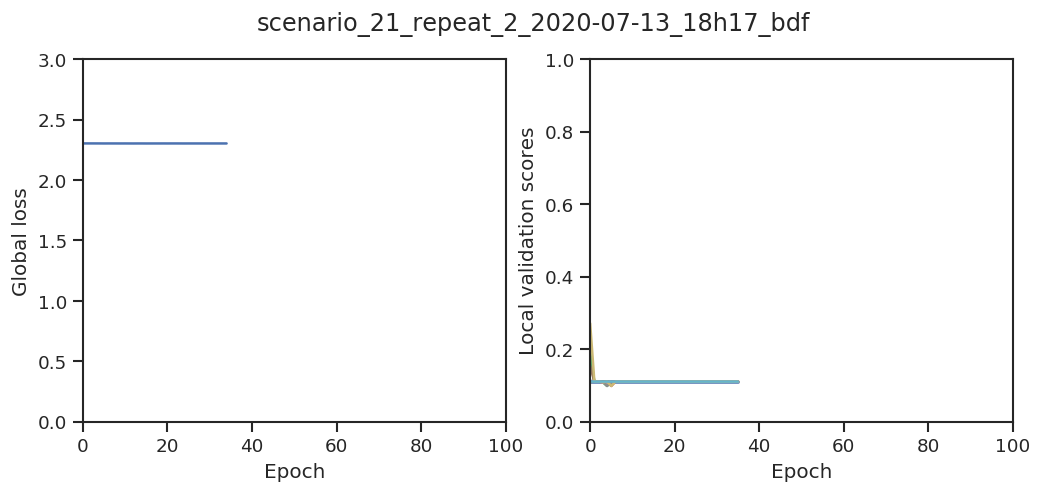

In [103]:
seq_scenario_names_list = df_seq.scenario_name

for scenario_name in df_seq.scenario_name:
    scenario_path = experiment_path / scenario_name
    history_data_path = scenario_path / "history_data.p"
    
    with open(history_data_path, 'rb') as f:
        loss_data = pickle.load(f)

    loss_collective_models = loss_data["loss_collective_models"]
    loss_collective_models =loss_collective_models[1:] # TODO Why first loss is nan ?

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120)
    fig.suptitle(scenario_name)

    ax1.plot(np.arange(len(loss_collective_models)), loss_collective_models)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Global loss")
    ax1.set_ylim([0, 3])
    ax1.set_xlim([0, df_seq.epoch_count.max()])

    score_matrix_per_partner = loss_data["score_matrix_per_partner"]
    score_matrix_per_partner.shape
    score_matrix_per_partner[score_matrix_per_partner == 0] = 'nan'
    local_validation_score = score_matrix_per_partner[:, 0, :]
    
    ax2.plot(np.arange(len(local_validation_score)), local_validation_score)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Local validation scores")
    ax2.set_ylim([0, 1])
    ax2.set_xlim([0, df_seq.epoch_count.max()])

In [114]:
400 / 60

6.666666666666667